### ✔패키지 설치 및 import

Colab과 LMS의 Jupyternotebook에 설치된 패키지의 버전이 다르므로 미리 설치해줍니다.

In [ ]:
# !pip install  --target=$my_path scikit-learn --upgrade missingno --upgrade  lightgbm --upgrade  xgboost --upgrade  statsmodels --upgrade

패키지들의 버전확인

In [ ]:
import sklearn
import statsmodels
import xgboost
import lightgbm
import missingno
print(sklearn.__version__)
print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(statsmodels.__version__)

1.0.2
1.6.1
3.3.2
0.5.1
0.13.2


In [ ]:
import warnings
warnings.filterwarnings("ignore")

from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## ✔EDA

사용할 데이터를 구글 드라이브에서 불러옵니다.

In [ ]:
train_data_path = '/content/drive/MyDrive/Data/kaggle-kakr-housing-data/train.csv'
test_data_path = '/content/drive/MyDrive/Data/kaggle-kakr-housing-data/test.csv'

In [ ]:
data = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [ ]:
data.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [ ]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


✔데이터의  columns & Shape

데이터들의 column들의 정보는 다음과 같습니다.

- `ID` : 집을 구분하는 번호


- `date` : 집을 구매한 날짜


- `price` : 집의 가격(Target variable)


- `bedrooms` : 침실의 수


- `bathrooms` : 침실 개수 당 화장실의 수(화장실의 수 / 침실의 수 )


- `sqft_living` : 주거 공간의 평방 피트(면적)


- `sqft_lot` : 부지의 평방 피트(면적)


- `floors` : 집의 층 수


- `waterfront` : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)


- `view` : 집이 얼마나 좋아 보이는지의 정도


- `condition` : 집의 전반적인 상태


- `grade` : King County grading 시스템 기준으로 매긴 집의 등급


- `sqft_above` : 지하실을 제외한 평방 피트(면적)


- `sqft_basement` : 지하실의 평방 피트(면적)


- `yr_built` : 지어진 년도


- `yr_renovated` : 집을 재건축한 년도


- `zipcode` : 우편번호


- `lat` : 위도


- `long` : 경도


- `sqft_living15` : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)


- `sqft_lot15` : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

위의 설명은 다음 링크에서 가져왔습니다.$^{[1]}$

[
https://www.kaggle.com/code/kcs93023/2019-ml-month-2nd-baseline/notebook
]

---

In [ ]:
print('train data dim : {}'.format(data.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


In [ ]:
print(data.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


⚡Train data의 컬럼갯수

In [ ]:
len(data.columns)

21

In [ ]:
print(test.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


⚡Test data의 컬럼 갯수

In [ ]:
len(test.columns)

20

Train 데이터는 price cloumn이 있으므로 21개 Test 데이터는 price column이 없으므로 20개입니다.

---

info함수를 사용하여 데이터의 정보를 보면.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

Train data set에는 결측치가 없습니다.

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

Test data set 또한 결측치가 없습니다.

결측치는 없으므로 보완해줄 필요는 없습니다.

아래는 위에서 데이터의 column에 대한 설명을 보고 **어떤 자료형일지 추측**했고 info에 나타난 결과와 비교했습니다. (id는 넘버링정도의 의미이므로 제외)

|    |feature |type|
|----|:----|:----:|
|row1|date | 정수형 X >> object|
|row2|price | 실수형 o  | 
|row3|bedrooms |정수형 o   |
|row4|bathrooms| 실수형 o  |
|row5|sqft_living|실수형 X >> int   |
|row6|sqft_lot|실수형 X >> int   |
|row7|floors| 집의 층 수 정수형 X >> 실수형  |
|row8|waterfront| 정수형 o  |
|row9|view|  정수형 o |
|row10|condition | 정수형 o  |
|row11|grade|  정수형 o |
|row12|sqft_above| 실수형 X >> int   |
|row13|sqft_basement| 실수형 X >> int   |
|row14|yr_built |정수형 o   |
|row15|yr_renovated| 정수형 o  |
|row16|zipcode| 정수형 o  |
|row17|lat   |  실수형 o |
|row18|long   | 실수형 o  |
|row19| sqft_living15  | 실수형 X >> int  |
|row20|  sqft_lot15 | 실수형 X >> int  |




-----

평방피트를 측정한 결과들이 실수형이 아닌 정수형 데이터였고,

집의 층 수는 정수형 자료일 줄 알았으나 놀랍게도 실수형 데이터였습니다. 0.5층을 셀 수 있나봅니다.

아래 링크에 따르면 다락방이 있는경우는 0.5층이라 한다는것 같습니다.$^{[2]}$

[ https://www.kaggle.com/code/chocozzz/house-price-prediction-eda-updated-2019-03-12/notebook ]




## 데이터의 분포

목적 변수는 Price이므로 Price의 분포를 시각화 하겠습니다.



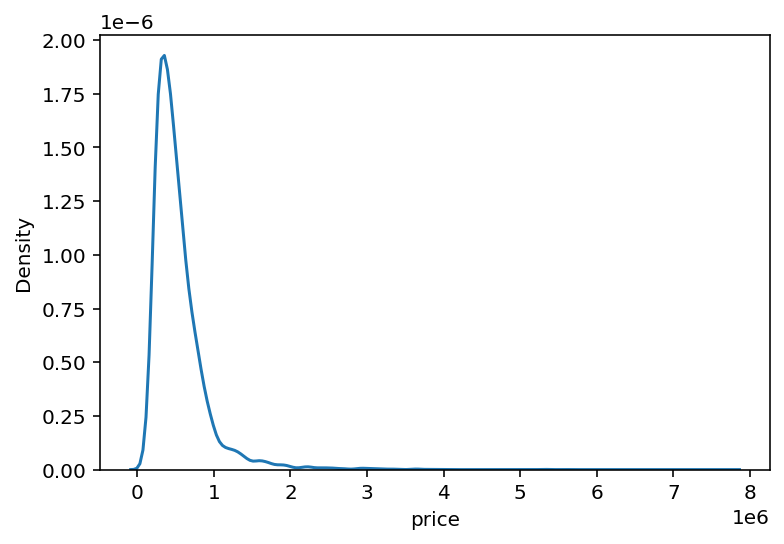

In [ ]:
#커널 밀도함수로 price의 분포 출력.
sns.kdeplot(data['price'])

그래프의 모양을 보면 데이터의 분포가 한쪽으로 치우쳐져있고, 정규분포를 따르지 않는 모양임을 알 수 있습니다. 데이터를 더 자세히 보면

In [ ]:
data['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

min      7.800000e+04

max      7.700000e+06

std      3.715247e+05

다음과 같이 집값의 최대와 최소, 표준편차가 매우 큰 것으로 보아 데이터의 불균형이 있습니다. 

또한 집값의 max치가 min값의 100배정도 되는 크기인데 이를 outlier로 보아야 할지 아니면 실제로 존재하는 값인지는 알아봐야 알 것 같습니다.


또한 해석에 있어서 편향성을 줄이기위해 Price cloumn을 정규화 시킨 후 다른 column들과의 상관관계를 분석해보려 합니다.

## Price와 다른 column들의 상관관계 분석.

20개의 feature를 갖고 있는 dataset에서 모든 변수들이 price와는 깊게 연관되어 있지는 않다고 판단됩니다.

따라서 여러가지 방법을 사용해 특성을 갖는 변수와 목적변수와의 관계가 낮다고 판단되는 feature를 제거하려 합니다.

###  1. SelectKBest 함수 사용해보기

코드는 다음 링크를 참고하였습니다.$^{[3]}$


[
    https://blog.naver.com/PostView.nhn?blogId=now2go&logNo=222119231886
]

In [ ]:
#id 컬럼 삭제
#date 컬럼 정수형으로 변환.
data_id = data['id']
del data['id']
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)

In [ ]:
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


#### 정규화 이전 Feature 추출

처음은 각 데이터들을 정규화 하지 않은 상태로 feature들을 추출해보겠습니다.

In [ ]:
from sklearn.model_selection import train_test_split
X = data[data.columns.difference(['price'])]
y = data[['price']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(data.shape)

(12028, 19)
(3007, 19)
(12028, 1)
(3007, 1)
(15035, 20)


20개 feature들의 중간값인 10개를 골라보도록 하겠습니다.

In [ ]:
# target(Price)와 가장 correlated 된 features 를 k개 고르기.
## f_regresison, SelectKBest 불러오기.
from sklearn.feature_selection import f_regression, SelectKBest
## selctor 정의하기.
selector = SelectKBest(score_func=f_regression, k=10)
## 학습데이터에 fit_transform 
X_train_selected = selector.fit_transform(X_train, y_train)
## 테스트 데이터는 transform
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape

((12028, 10), (3007, 10))

In [ ]:
all_names = X_train.columns
## selector.get_support()
selected_mask = selector.get_support()
## 선택된 특성(변수)들
selected_names = all_names[selected_mask]
## 선택되지 않은 특성(변수)들
unselected_names = all_names[~selected_mask]
print('Selected names: ', selected_names)
print('Unselected names: ', unselected_names)

Selected names:  Index(['bathrooms', 'bedrooms', 'floors', 'grade', 'lat', 'sqft_above',
       'sqft_basement', 'sqft_living', 'sqft_living15', 'view'],
      dtype='object')
Unselected names:  Index(['condition', 'date', 'long', 'sqft_lot', 'sqft_lot15', 'waterfront',
       'yr_built', 'yr_renovated', 'zipcode'],
      dtype='object')


정규화 전 SelectKBest 함수가 고른 feature들은 다음과 같습니다.

['bathrooms', 'bedrooms', 'grade', 'lat', 'sqft_above', 'sqft_basement',
       'sqft_living', 'sqft_living15', 'view', 'waterfront']

#### 정규화 이후 Feature 선택

다음은 standardization 이후의 데이터를 가지고 feature를 선택해보려 합니다.

In [ ]:
from sklearn.preprocessing import StandardScaler
data_standard = StandardScaler().fit_transform(data)
data_standard = pd.DataFrame(data_standard, columns=data.columns, index=list(data.index.values))

In [ ]:
data_standard

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,-0.645099,-0.858068,-0.408931,-1.452865,-0.980140,-0.226394,-0.924917,-0.084662,-0.306875,-0.62902,-0.560048,-0.738427,-0.657286,-0.547510,-0.209296,1.875717,-0.358430,-0.306626,-0.944060,-0.258655
1,1.433970,-0.970850,-1.516730,-1.452865,-1.424775,-0.124309,-0.924917,-0.084662,-0.306875,-0.62902,-1.407676,-1.231387,-0.657286,-1.295641,-0.209296,-0.938751,1.282425,-0.136763,1.051794,-0.171690
2,1.433970,-0.082589,-0.408931,-0.149923,-0.437901,-0.169367,-0.924917,-0.084662,-0.306875,-0.62902,0.287579,-0.137257,-0.657286,0.540680,-0.209296,-0.075648,0.405903,1.193836,-0.278776,-0.191845
3,-0.735493,-0.762243,-0.408931,0.175813,-0.399945,-0.198960,0.932080,-0.084662,-0.306875,-0.62902,-0.560048,-0.095175,-0.657286,0.812727,-0.209296,-1.407829,-1.816888,-0.802062,0.354691,-0.216507
4,1.411372,-0.669783,-0.408931,-0.801394,-1.110277,-0.131091,-0.924917,-0.084662,-0.306875,-0.62902,-0.560048,-0.882708,-0.657286,-0.275463,-0.209296,2.250979,-1.094536,-0.717130,-0.495716,-0.112235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,-0.645099,0.188425,0.698868,0.501548,0.473059,-0.217640,0.932080,-0.084662,-0.306875,-0.62902,1.135206,0.872709,-0.657286,1.458840,-0.209296,-0.413384,-0.340335,0.330362,0.762539,-0.245206
15031,1.456569,1.256533,0.698868,1.804491,1.546692,-0.190019,0.932080,-0.084662,-0.306875,-0.62902,1.135206,0.968897,1.407852,1.288810,-0.209296,1.087666,-0.050815,-1.304575,0.082792,-0.238825
15032,-0.758092,-0.486344,-0.408931,0.501548,-0.600573,-0.332445,2.789078,-0.084662,-0.306875,-0.62902,0.287579,-0.317608,-0.657286,1.288810,-0.209296,0.468483,1.003038,-0.936538,-0.669269,-0.407959
15033,1.433970,-0.378676,0.698868,0.501548,0.245319,-0.222569,0.932080,-0.084662,-0.306875,-0.62902,0.287579,0.620218,-0.657286,1.458840,-0.209296,1.275297,-0.362049,-1.049780,-0.235387,-0.202770


In [ ]:
X_std = data_standard[data_standard.columns.difference(['price'])]
y_std = data_standard[['price']]
X_train_std1, X_test_std1, y_train_std1, y_test_std1 = train_test_split(X_std, y_std, train_size=0.8, test_size=0.2)
print(X_train_std1.shape)
print(X_test_std1.shape)
print(y_train_std1.shape)
print(y_test_std1.shape)
print(data.shape)

(12028, 19)
(3007, 19)
(12028, 1)
(3007, 1)
(15035, 20)


In [ ]:
## 학습데이터에 fit_transform 
X_train_selected = selector.fit_transform(X_train_std1, y_train_std1)
## 테스트 데이터는 transform
X_test_selected = selector.transform(X_test_std1)
X_train_selected.shape, X_test_selected.shape

((12028, 10), (3007, 10))

In [ ]:
all_names = X_train_std1.columns
## selector.get_support()
selected_mask2 = selector.get_support()
## 선택된 특성(변수)들
selected_names2 = all_names[selected_mask2]
## 선택되지 않은 특성(변수)들
unselected_names2 = all_names[~selected_mask2]
print('Selected names: ', selected_names2)
print('Unselected names: ', unselected_names2)

Selected names:  Index(['bathrooms', 'bedrooms', 'floors', 'grade', 'lat', 'sqft_above',
       'sqft_basement', 'sqft_living', 'sqft_living15', 'view'],
      dtype='object')
Unselected names:  Index(['condition', 'date', 'long', 'sqft_lot', 'sqft_lot15', 'waterfront',
       'yr_built', 'yr_renovated', 'zipcode'],
      dtype='object')


정규화 후 선택된 feature

['bathrooms', 'bedrooms', 'floors', 'grade', 'lat', 'sqft_above',
       'sqft_basement', 'sqft_living', 'sqft_living15', 'view']

정규화 이전 선택된 feature

['bathrooms', 'bedrooms', 'grade', 'lat', 'sqft_above', 'sqft_basement',
       'sqft_living', 'sqft_living15', 'view', 'waterfront']

**공통으로 선택된 feature**

['bathrooms', 'bedrooms', 'grade', 'lat', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15', 'view'] 의 9개 항목


정규화 이전  **waterfront** 선택됨 > 정규화 후 **floors** 선택됨

### 2.SelectPercentile 함수 사용해보기.
일변량 통계

특성과 타켓 사이에 중요한 통계적 관계가 있는지 계산하고 깊게 관련된 것만 선택합니다.

코드는 다음 링크를 참고하였습니다.$^{[4]}$

[
https://inuplace.tistory.com/618
]

In [ ]:
from sklearn.feature_selection import SelectPercentile
all_names = X_train.columns

# SelectPercentile을 사용하여 특성의 55%를 선택하는 모델 생성
select_sp = SelectPercentile(percentile=55)

# 특성 선택 정규화 전
select_sp.fit(X_train, y_train)
X_train_selected3 = select_sp.transform(X_train)
selected_mask3 = select_sp.get_support()

## 선택된 특성(변수)들
selected_names3 = all_names[selected_mask3]
## 선택되지 않은 특성(변수)들
unselected_names3 = all_names[~selected_mask3]
print('Selected names: ', selected_names3)
print('Unselected names: ', unselected_names3)


Selected names:  Index(['bathrooms', 'bedrooms', 'grade', 'lat', 'sqft_above', 'sqft_basement',
       'sqft_living', 'sqft_living15', 'view', 'waterfront'],
      dtype='object')
Unselected names:  Index(['condition', 'date', 'floors', 'long', 'sqft_lot', 'sqft_lot15',
       'yr_built', 'yr_renovated', 'zipcode'],
      dtype='object')


In [ ]:
# 특성 선택 정규화 후
select_sp.fit(X_train_std1, y_train_std1)
X_train_selected4 = select_sp.transform(X_train_std1)
selected_mask4 = select_sp.get_support()

## 선택된 특성(변수)들
selected_names4 = all_names[selected_mask4]
## 선택되지 않은 특성(변수)들
unselected_names4 = all_names[~selected_mask4]
print('Selected names: ', selected_names4)
print('Unselected names: ', unselected_names4)

Selected names:  Index(['bathrooms', 'bedrooms', 'grade', 'lat', 'sqft_above', 'sqft_basement',
       'sqft_living', 'sqft_living15', 'view', 'waterfront'],
      dtype='object')
Unselected names:  Index(['condition', 'date', 'floors', 'long', 'sqft_lot', 'sqft_lot15',
       'yr_built', 'yr_renovated', 'zipcode'],
      dtype='object')


SelectPercentile 라이브러리를 사용했을 때 정규화 전 후 선택된 feature는 차이가 없다.

## 2개 라이브러리를 사용해본 결과 

각각

1. [ 'bathrooms', 'bedrooms', 'floors', 'grade', 'lat', 'sqft_above','sqft_basement', 'sqft_living', 'sqft_living15', 'view' ] > 1회

2.  ['bathrooms', 'bedrooms', 'grade', 'lat', 'sqft_above', 'sqft_basement',
'sqft_living', 'sqft_living15', 'view', 'waterfront'] > 3회


feature들을 선택했다.

## ✔모델링

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test,y_pred))

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [ ]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [ ]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [ ]:
X = data[data.columns.difference(['price'])]

In [ ]:
X

,bathrooms,bedrooms,condition,date,floors,grade,lat,long,sqft_above,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,yr_built,yr_renovated,zipcode
0,1.00,3,3,201410,1.0,7,47.5112,-122.257,1180,0,1180,1340,5650,5650,0,0,1955,0,98178
1,1.00,2,3,201502,1.0,6,47.7379,-122.233,770,0,770,2720,10000,8062,0,0,1933,0,98028
2,2.00,3,3,201502,1.0,8,47.6168,-122.045,1680,0,1680,1800,8080,7503,0,0,1987,0,98074
3,2.25,3,3,201406,2.0,7,47.3097,-122.327,1715,0,1715,2238,6819,6819,0,0,1995,0,98003
4,1.50,3,3,201501,1.0,7,47.4095,-122.315,1060,0,1060,1650,9711,9711,0,0,1963,0,98198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,2.50,4,3,201410,2.0,9,47.5137,-122.167,2520,0,2520,2520,6023,6023,0,0,2014,0,98056
15031,3.50,4,3,201503,2.0,9,47.5537,-122.398,2600,910,3510,2050,7200,6200,0,0,2009,0,98136
15032,2.50,3,3,201405,3.0,8,47.6993,-122.346,1530,0,1530,1530,1131,1509,0,0,2009,0,98103
15033,2.50,4,3,201502,2.0,8,47.5107,-122.362,2310,0,2310,1830,5813,7200,0,0,2014,0,98146


In [ ]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 130560.4599441772,
 'LGBMRegressor': 120637.37922563334,
 'RandomForestRegressor': 125312.06662626054,
 'XGBRegressor': 120006.99036153084}

In [ ]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models,X , y)

,RMSE
GradientBoostingRegressor,130560.459944
RandomForestRegressor,125312.066626
LGBMRegressor,120637.379226
XGBRegressor,120006.990362


위에서 선택한 feature를 가지고 학습

Case.1 [ 'bathrooms', 'bedrooms', 'floors', 'grade', 'lat', 'sqft_above','sqft_basement', 'sqft_living', 'sqft_living15', 'view' ] 

Case.2 ['bathrooms', 'bedrooms', 'grade', 'lat', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15', 'view', 'waterfront']

In [ ]:
X1 =  data_standard[[ 'bathrooms', 'bedrooms', 'floors', 'grade', 'lat', 'sqft_above','sqft_basement', 'sqft_living', 'sqft_living15', 'view' ]]
X2 =  data_standard[['bathrooms', 'bedrooms', 'grade', 'lat', 'sqft_above', 'sqft_basement', 'sqft_living', 'sqft_living15', 'view', 'waterfront']]

In [ ]:
df1 = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(X1, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df1[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df1, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df1

{'GradientBoostingRegressor': 164594.08054168697,
 'LGBMRegressor': 161887.52947370074,
 'RandomForestRegressor': 164192.6249503797,
 'XGBRegressor': 162930.58059555467}

In [ ]:
df2 = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(X2, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df2[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df2, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df2

{'GradientBoostingRegressor': 160885.0718776489,
 'LGBMRegressor': 159002.0940547402,
 'RandomForestRegressor': 159727.6966169181,
 'XGBRegressor': 163409.5245056637}

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [ ]:
model = LGBMRegressor(random_state=random_state)

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
grid_model.cv_results_

{'mean_fit_time': array([0.16308217, 0.22952209, 0.42362599, 0.63522725]),
 'mean_score_time': array([0.02875924, 0.03302684, 0.04426732, 0.05023403]),
 'mean_test_score': array([-4.87273435e+10, -3.95851534e+10, -2.82199372e+10, -2.79903556e+10]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'rank_test_score': array([4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([-4.54633504e+10, -3.54963974e+10, -2.75436627e+10, -2.71061385e+10]),
 'split1_test_score': array([-4.09018554e+10, -3.35645038e+10, -2.42715801e+10, -2.45671084e+10]),
 'split

In [ ]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [ ]:
score = grid_model.cv_results_['mean_test_score']
score

array([-4.87273435e+10, -3.95851534e+10, -2.82199372e+10, -2.79903556e+10])

In [ ]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-4.872734e+10
1,1,100,-3.958515e+10
2,10,50,-2.821994e+10
3,10,100,-2.799036e+10


In [ ]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-4.872734e+10,220742.708892
1,1,100,-3.958515e+10,198960.180374
2,10,50,-2.821994e+10,167987.907904
3,10,100,-2.799036e+10,167303.184613


In [ ]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSE')

    return results

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, X1, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSE
3,10,100,-2.812397e+10,167702.018859
2,10,50,-2.855105e+10,168970.555410
1,1,100,-3.916646e+10,197905.190718
0,1,50,-4.776147e+10,218543.981739


In [ ]:
test = test[[ 'bathrooms', 'bedrooms', 'floors', 'grade', 'lat', 'sqft_above','sqft_basement', 'sqft_living', 'sqft_living15', 'view' ]]

In [ ]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(X1, y)
prediction = model.predict(test)

prediction

array([3424213.35406263, 3204034.29596003, 3611130.75903159, ...,
       3400217.24873539, 3020807.83390382, 2977023.19893663])

In [ ]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    data_dir = '/content/drive/MyDrive/Data/kaggle-kakr-housing-data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSE_{}.csv'.format(data_dir, model_name, rmse)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [ ]:
save_submission(model, X1, y,test, 'lgbm', rmsle='167702')

/content/drive/MyDrive/Data/kaggle-kakr-housing-data/submission_lgbm_RMSE_<function rmse at 0x7f79843729e0>.csv saved!


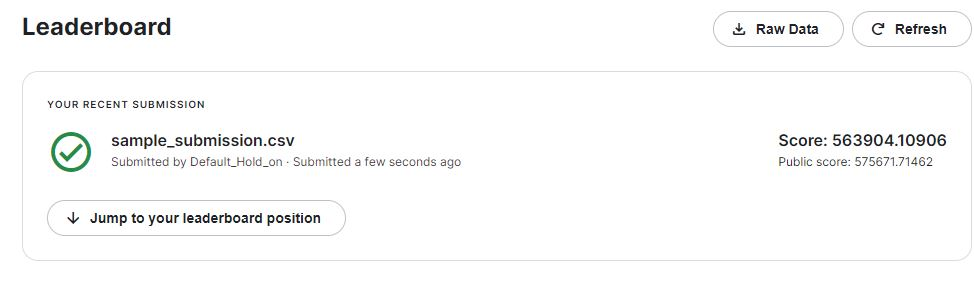

망했다.

# End

아이펠에서 공부하면서 현 상황에서 제일 아쉬운 익스 노드였다.

데이터 분석기법을 제대로 익히지 못한 상태에서 시작해서 EDA, feature engineering 제대로 된 모델링 도 못하고 결과 제출하기 급급해서 그냥 실망스러웠다. 

그나마 시도해본 것이 Feature 간소화를 위해 다른 라이브러리를 활용해 보았다 정도인데.. 결과도 좋지 않고 나머지는 거의 한 것이 없다.

이번 노드를 통해 깨달은 점은 부족한 부분은 최대한 빨리 보충하고 보완해야 피를 안본다는 것,,,

현재 빨리 보완해야 할 점은

1. EDA 기법
2. Feature engineering 및 데이터 전처리 기법
3. 앙상블 모델 다루는 법
4. 데이터 프레임 다루는 법

으로 데이터를 분석하는 방법을 빨리 보완해야 다음 노드에서 수월하게 할 수 있을것 이다.
